# Import necessary libraries

In [1]:
# Uninstall TensorFlow
!pip uninstall tensorflow -y > /dev/null 2>&1

# Install TensorFlow
!pip install tensorflow > /dev/null 2>&1

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

2024-07-08 14:44:55.061640: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 14:44:55.087757: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 14:44:55.087806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load and preprocess the data
Load the data, convert the 'Date' column to datetime, fill missing values, set 'Date' as index, and drop the 'Name' column.


In [4]:
# Update the file path as needed
file_path = '/kaggle/input/cat-2006-01-01-to-2018-01-01/CAT_2006-01-01_to_2018-01-01.csv'

# Load the data from kaggle
data = pd.read_csv(file_path)

# Load the data from Local
# data = pd.read_csv('CAT_2006-01-01_to_2018-01-01.csv')

# Display the first few rows of the dataset
data.head()

,Date,Open,High,Low,Close,Volume,Name
0,2006-01-03,57.87,58.11,57.05,57.80,3697500,CAT
1,2006-01-04,57.95,59.43,57.55,59.27,4577200,CAT
2,2006-01-05,59.02,59.86,59.00,59.27,4590700,CAT
3,2006-01-06,59.47,60.76,59.38,60.45,5692300,CAT
4,2006-01-09,60.45,61.68,60.45,61.55,4409300,CAT


In [5]:
# Convert Date to datetime (making it easier to handle dates and times in the analysis.)
data['Date'] = pd.to_datetime(data['Date'])

# Fill missing values with the previous day's data
data.fillna(method='ffill', inplace=True)

# Set Date as the index(allowing for easier time series manipulation)
data.set_index('Date', inplace=True)

# Drop the 'Name' column as it's not useful for prediction
data.drop(columns=['Name'], inplace=True)

# Display the first few rows of the dataset
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,57.87,58.11,57.05,57.80,3697500
2006-01-04,57.95,59.43,57.55,59.27,4577200
2006-01-05,59.02,59.86,59.00,59.27,4590700
2006-01-06,59.47,60.76,59.38,60.45,5692300
2006-01-09,60.45,61.68,60.45,61.55,4409300


# Visualize the data

Plot the 'Close' price over time to visualize the data.

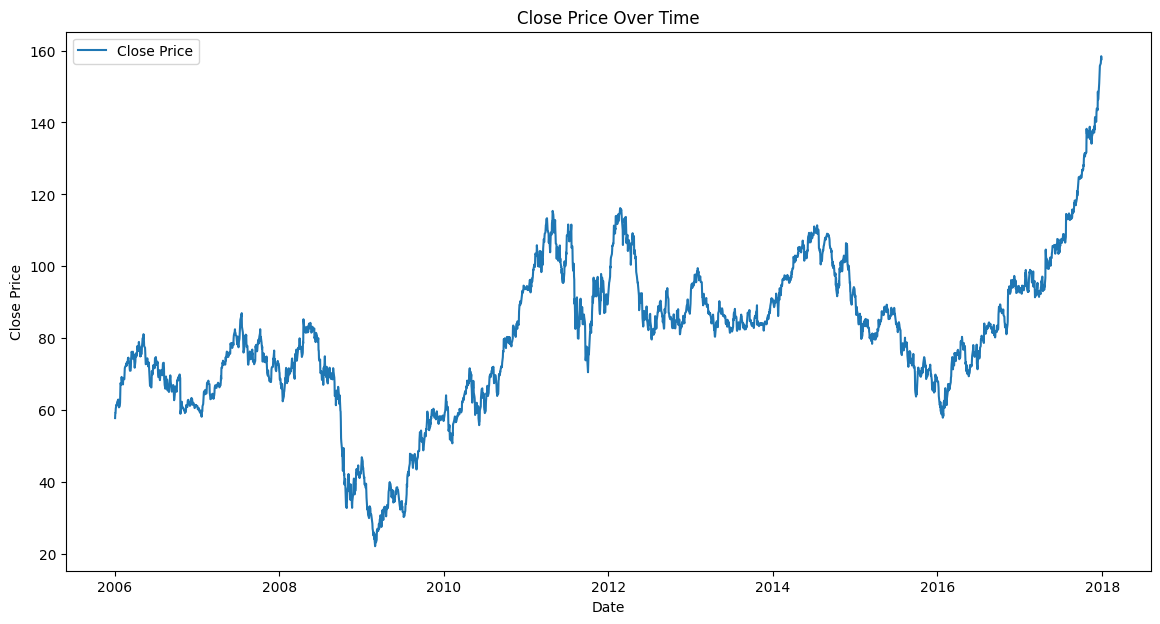

In [6]:
 import matplotlib.pyplot as plt

# Plot the 'Close' price over time
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Close Price')
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Normalize the data

Normalize the data using MinMaxScaler to scale the features to a given range (0 to 1).

In [7]:
from sklearn.preprocessing import MinMaxScaler

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Convert the scaled data back to a DataFrame for verification
scaled_data_df = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
scaled_data_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2006-01-03,0.260118,0.257240,0.260236,0.261505,0.052048
2006-01-04,0.260709,0.266992,0.263918,0.272294,0.065056
2006-01-05,0.268612,0.270168,0.274595,0.272294,0.065255
2006-01-06,0.271935,0.276817,0.277393,0.280954,0.081544
2006-01-09,0.279173,0.283614,0.285272,0.289028,0.062573


# Create sequences and labels

Define a function to create sequences of a given length from the data. These sequences will be used as input for the LSTM model, and the corresponding 'Close' prices will be the target labels.


In [8]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 3]  # 'Close' column index is 3
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
SEQ_LENGTH = 60
X, y = create_sequences(scaled_data, SEQ_LENGTH)

In [10]:
X.shape, y.shape

((2960, 60, 5), (2960,))

# Split data into train and test sets

Split the sequences into training and testing datasets to prepare for model training and evaluation.


In [11]:
# Determine the split point
split = int(0.8 * len(X))

# Split the data into training and testing sets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Display the shapes of the resulting arrays to verify the split
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2368, 60, 5), (592, 60, 5), (2368,), (592,))

# Define the LSTM model

In [12]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, 5)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

# Display the model summary to verify the architecture
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,451 (122.86 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

# Compile the model

Compile the LSTM model with the Adam optimizer and mean squared error loss function.

In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model

Train the LSTM model on the training data.

In [14]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0391 - val_loss: 5.6027e-04
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0023 - val_loss: 4.4158e-04
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 3.7953e-04
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0020 - val_loss: 7.8562e-04
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0019 - val_loss: 6.5809e-04
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017 - val_loss: 3.7545e-04
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 3.2087e-04
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 4.2397e-04
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015 - val_loss: 3.0875e-04
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0015 - val_loss: 4.5450e-04
Epoch 12/20
60/60 ━━━━━━━━━━━━━

# Evaluate the model

Evaluate the model on the test data to see the performance.

In [15]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.0638e-04
Test Loss: 0.000569166848435998


# Calculate R^2 Score and Plot Predictions

Calculate the R^2 score and plot the model's predictions against the actual values.

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R^2 Score: 0.9787875674741363


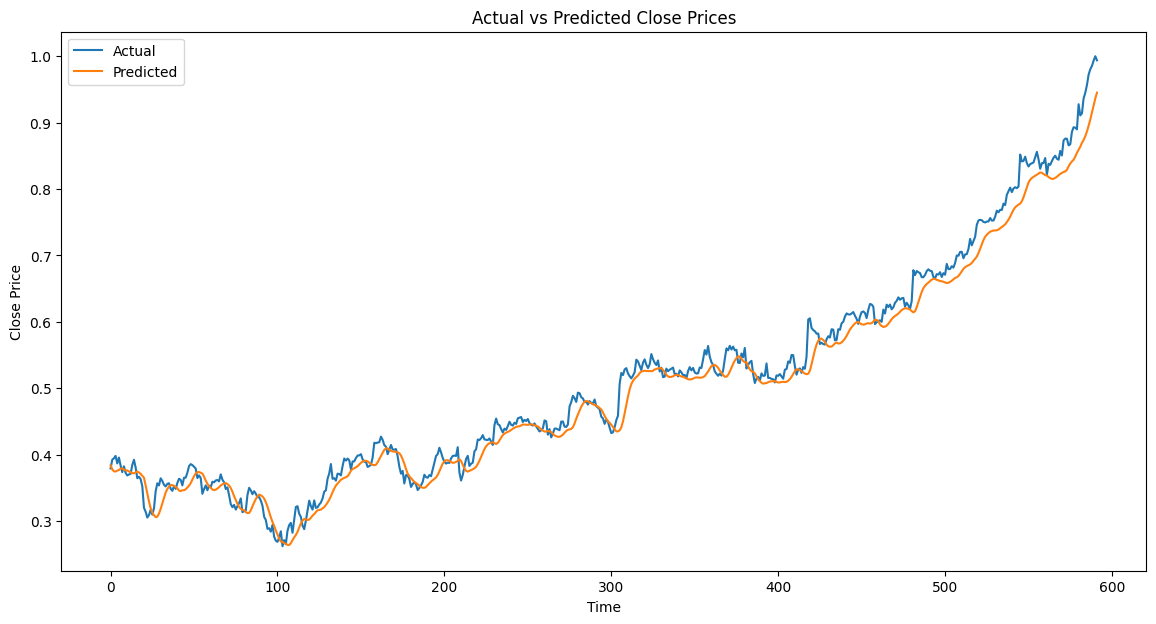

In [16]:
from sklearn.metrics import r2_score

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate the R^2 score
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Plot training and validation loss

Plot the training and validation loss over epochs to visualize the training process.


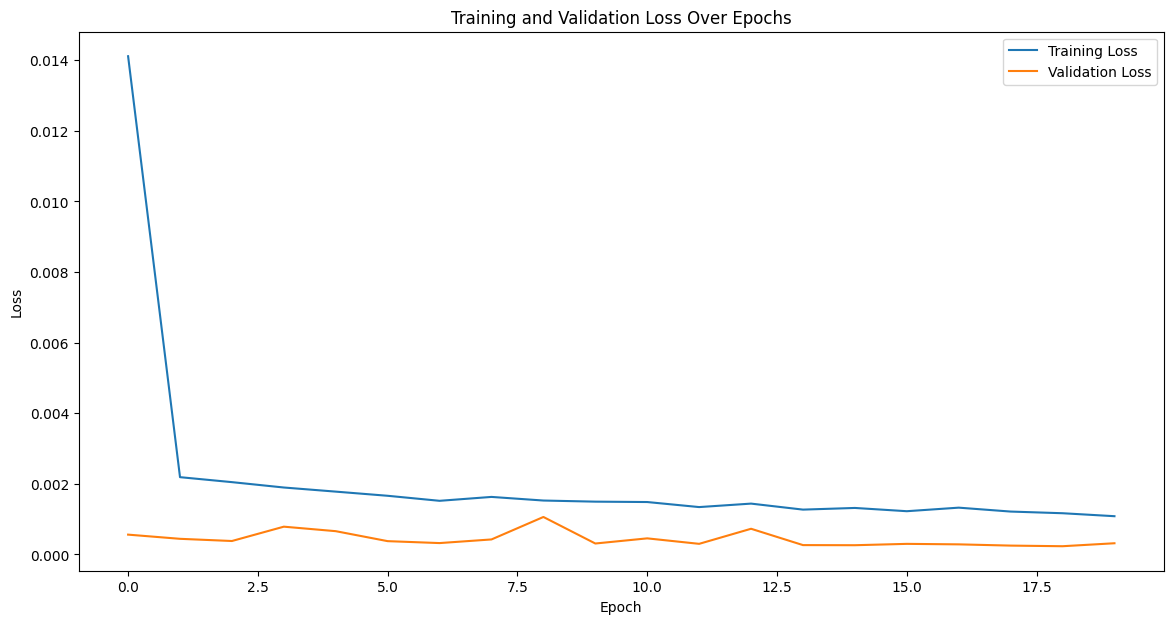

In [17]:
# Plot training and validation loss
plt.figure(figsize=(14, 7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Make future predictions

Use the trained model to make future predictions based on the latest available data.


In [18]:
# Select the latest data for making future predictions
latest_data = scaled_data[-SEQ_LENGTH:]

# Reshape the data to match the input shape of the model
latest_data = latest_data.reshape((1, SEQ_LENGTH, latest_data.shape[1]))

# Make predictions
future_prediction = model.predict(latest_data)

# Inverse transform the predictions to get the actual value
future_prediction = scaler.inverse_transform([[0, 0, 0, future_prediction[0][0], 0]])[0][3]

print(f'Future Prediction (Close Price): {future_prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Future Prediction (Close Price): 151.9521267694235


# Save the model

Save the trained LSTM model to a file so that it can be loaded and used later without retraining.


In [19]:
# Save the model to a file
model.save('lstm_model.h5')

# Load the saved model

Load the previously saved LSTM model from a file to use it for making predictions or further evaluations.

In [20]:
# Load the model from the file
loaded_model = tf.keras.models.load_model('lstm_model.h5')

# Display the model summary to verify successful loading
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,453 (122.87 KB)

 Trainable params: 31,451 (122.86 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

# Make predictions with the loaded model

Use the loaded model to make predictions on the test data and compare with the original model's predictions to ensure they match.


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R^2 Score for Loaded Model: 0.9787875674741363


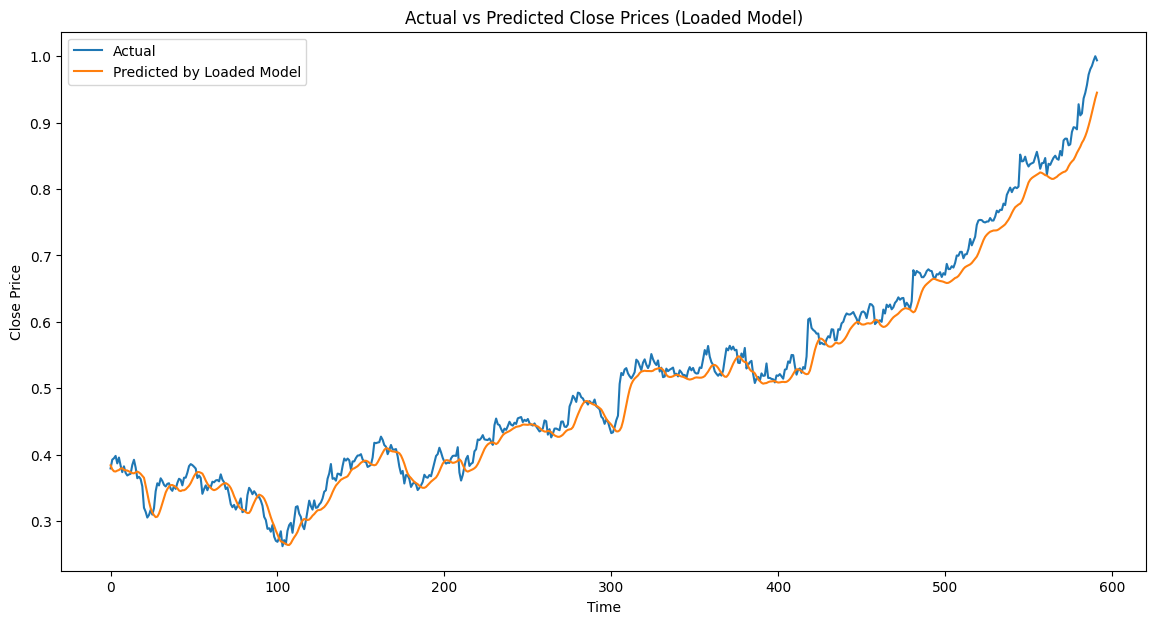

In [21]:
# Make predictions on the test set with the loaded model
loaded_y_pred = loaded_model.predict(X_test)

# Calculate the R^2 score for the loaded model's predictions
loaded_r2 = r2_score(y_test, loaded_y_pred)
print(f'R^2 Score for Loaded Model: {loaded_r2}')

# Plot the actual vs predicted values for the loaded model
plt.figure(figsize=(14, 7))
plt.plot(y_test, label='Actual')
plt.plot(loaded_y_pred, label='Predicted by Loaded Model')
plt.title('Actual vs Predicted Close Prices (Loaded Model)')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Perform predictions on new, unseen data

Prepare some new data (not part of the training or testing sets) and use the loaded model to make predictions.


In [22]:
# Example new data for prediction (this should be actual new data in a real scenario)
# Here, we use the last available sequence from the dataset for demonstration
new_data = scaled_data[-SEQ_LENGTH:]

# Reshape the new data to match the input shape of the model
new_data = new_data.reshape((1, SEQ_LENGTH, new_data.shape[1]))

# Make predictions with the loaded model
new_prediction = loaded_model.predict(new_data)

# Inverse transform the prediction to get the actual value
new_prediction = scaler.inverse_transform([[0, 0, 0, new_prediction[0][0], 0]])[0][3]

print(f'New Prediction (Close Price): {new_prediction}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
New Prediction (Close Price): 151.9521267694235


Plot the new prediction alongside the actual data for visual comparison.

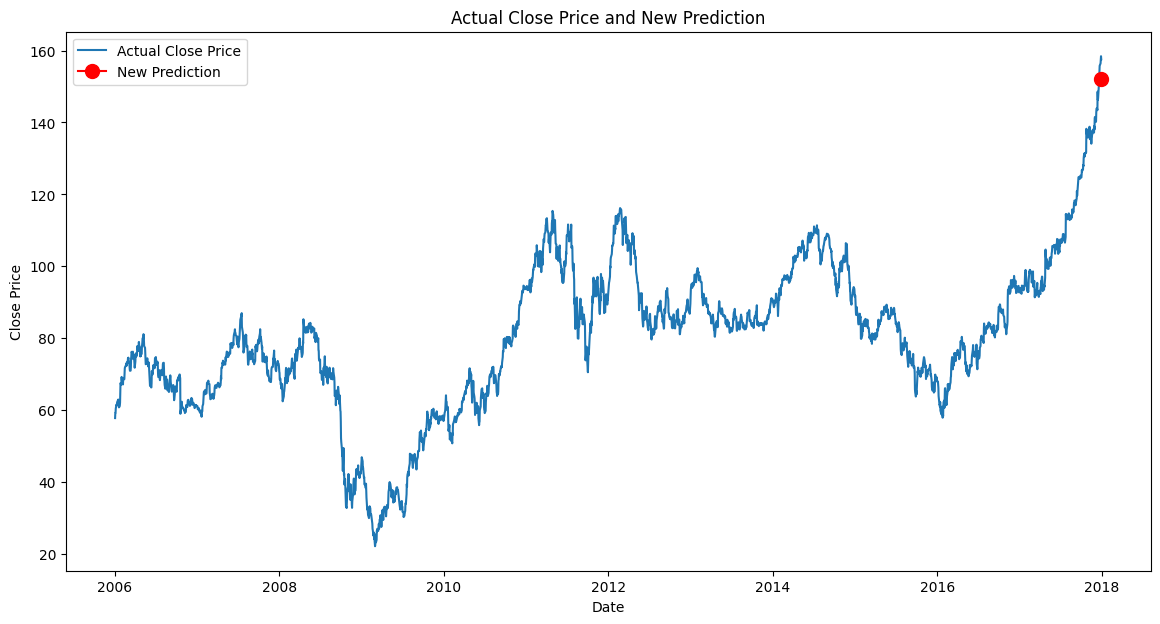

In [23]:
# Plot the actual data and the new prediction
plt.figure(figsize=(14, 7))

# Plot the actual 'Close' prices (up to the last available data point)
plt.plot(data.index, data['Close'], label='Actual Close Price')

# Plot the new prediction (extend the index by one time step for the prediction)
plt.plot(data.index[-1:] + pd.to_timedelta(1, unit='D'), [new_prediction], marker='o', markersize=10, color='red', label='New Prediction')

plt.title('Actual Close Price and New Prediction')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# Create a DataFrame with actual and predicted 'Close' prices

Create a DataFrame that includes the actual 'Close' prices, predicted 'Close' prices, and compare them.


In [24]:
# Make predictions on the entire dataset to compare with actual values
full_predictions = model.predict(X)

# Inverse transform the predictions to get the actual values
full_predictions = scaler.inverse_transform([[0, 0, 0, pred[0], 0] for pred in full_predictions])[:, 3]

# Create a DataFrame with the actual and predicted 'Close' prices
comparison_df = pd.DataFrame({
    'Date': data.index[SEQ_LENGTH:],  # The dates corresponding to the predictions
    'Actual Close': data['Close'][SEQ_LENGTH:],  # The actual 'Close' prices
    'Predicted Close': full_predictions  # The predicted 'Close' prices
})

# Set the 'Date' column as the index
comparison_df.set_index('Date', inplace=True)

# Display the DataFrame
comparison_df.head(20)

93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


,Actual Close,Predicted Close
Date,,
2006-03-30,72.40,74.890624
2006-03-31,71.81,74.439040
2006-04-03,73.50,73.845369
2006-04-04,75.30,73.365516
2006-04-05,75.80,73.162609
2006-04-06,75.65,73.234262
2006-04-07,74.92,73.493359
2006-04-10,75.45,73.771499
2006-04-11,76.66,74.043200


# Plot actual vs. predicted 'Close' prices over time

Plot the actual 'Close' prices and the predicted 'Close' prices from the comparison DataFrame.


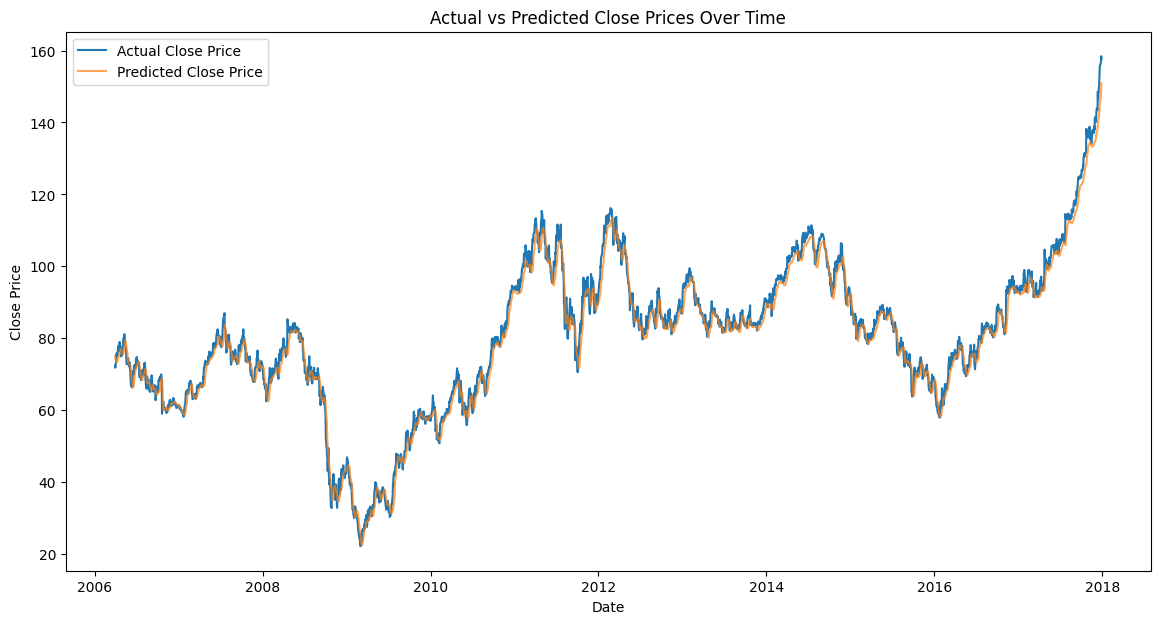

In [25]:
plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df['Actual Close'], label='Actual Close Price')
plt.plot(comparison_df.index, comparison_df['Predicted Close'], label='Predicted Close Price', alpha=0.7)
plt.title('Actual vs Predicted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [26]:
# Amir Miri